In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [9]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=[
        tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
        tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
        tfds.Split.TRAIN.subsplit(tfds.percent[90:])
    ],
    with_info=True,
    as_supervised=True
)


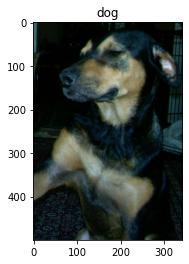

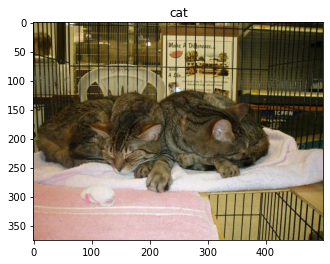

In [11]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
plt.show()

In [17]:
IMG_SIZE = 160

def format_example(image, label):
    """
    returns an image that is reshaped to IMG_SIZE
    """
    image = tf.cast(image, tf.float32)
    # normalize to [-1, 1]
    image = (image/(255. / 2.)) - 1.
    # resize to 160x160
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [18]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

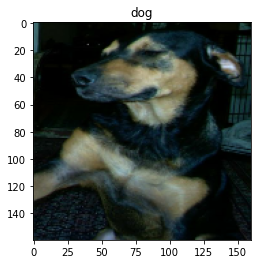

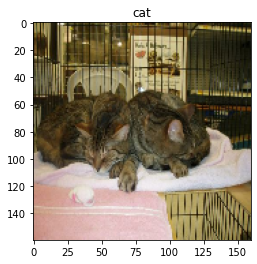

In [28]:
for image, label in train.take(2):
    plt.figure()
    plt.imshow((image + 1) * 0.5)
    plt.title(get_label_name(label))
plt.show()

In [30]:
for img, label in raw_train.take(2):
    print("Original shape:", img.shape)
for img, label in train.take(2):
    print("New shape:", img.shape)

Original shape: (500, 343, 3)
Original shape: (375, 500, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


In [31]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [32]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [34]:
base_model.trainable = False

In [35]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [36]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)

In [37]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [51]:
BATCH_SIZE = 32

train_batches = train.batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [52]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [55]:
tf.config.run_functions_eagerly(True)

In [56]:
initial_epochs = 3
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)


20/20 [==============================] - 11s 525ms/step - loss: 0.6752 - accuracy: 0.5437


In [57]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
     38/Unknown - 75s 2s/step - loss: 0.5822 - accuracy: 0.5938

In [ ]:
model.save("dogs_vs_cats.h5")
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')